**Trabalho Prático 01**\
**Aprendizado Profundo para Processamento de Linguagem Natural**

**Isabela Saenz Cardoso\
2021040032**

Intrinsic evaluation\
Code: gensim\
Corpus: https://mattmahoney.net/dc/text8.zip\

Pre-processing:
- Punctuation, lower case, etc.

Choices:
- Training sizes, window sizes, CBOW vs Skip-Gram.

Evaluation:
- Analogies using https://github.com/nicholas-leonard/word2vec/blob/master/questions-words.txt
- Input three words, pick the returned word, compute the distance to the correct word
- Repeat and average.

---
###Instalations and imports



In [ ]:
!pip install optuna

In [ ]:
import os
import itertools
import string

import requests
from io import BytesIO
from io import StringIO
import zipfile

import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models.word2vec import LineSentence

import optuna

from scipy.spatial.distance import cosine

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Download and extract the Text8 corpus
url = "https://mattmahoney.net/dc/text8.zip"
response = requests.get(url)
zipped_file = zipfile.ZipFile(BytesIO(response.content))
zipped_file.extractall()
corpus_path = "/content/text8"

In [ ]:
!wget https://github.com/nicholas-leonard/word2vec/blob/master/questions-words.txt

--2023-11-11 23:19:21--  https://github.com/nicholas-leonard/word2vec/blob/master/questions-words.txt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 707044 (690K) [text/plain]
Saving to: ‘questions-words.txt.2’

questions-words.txt 100%[===================>] 690.47K  --.-KB/s    in 0.08s   

2023-11-11 23:19:21 (8.91 MB/s) - ‘questions-words.txt.2’ saved [707044/707044]



In [ ]:
# Load and parse the analogical reasoning dataset
with open(datapath('questions-words.txt'), 'r') as f:
    data = f.read()

def parse_questions(data):
    questions = []
    for line in data:
        if line.startswith(':'):
            continue
        words = line.split()
        if len(words) == 4:
            questions.append(words)
    return questions

data = StringIO(data)
questions = parse_questions(data)
print(questions[:5])

[['Athens', 'Greece', 'Baghdad', 'Iraq'], ['Athens', 'Greece', 'Bangkok', 'Thailand'], ['Athens', 'Greece', 'Beijing', 'China'], ['Athens', 'Greece', 'Berlin', 'Germany'], ['Athens', 'Greece', 'Bern', 'Switzerland']]




---

### Preprocessing

The preprocessing section aims to clean and tokenize the Text8 corpus sentences before training the Word2Vec model. The following steps are performed:

- **Tokenization and Lowercasing:** The sentences are tokenized into words, and all words are converted to lowercase for uniformity.
- **Removal of Stop Words and Punctuation:** Common English stop words and punctuation are removed from the tokenized words to focus on meaningful content.
- **Lemmatization:** Words are lemmatized using WordNet, reducing them to their base or root form.


In [ ]:
# Define preprocessing function
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = [word.lower() for word in text.split()]
    stop_words = set(stopwords.words('english'))
    tokens = [word.translate(str.maketrans('', '', string.punctuation)) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]

    return tokens


Lemmatization is the process of reducing words to their base or root form, ensuring variations like verb conjugations or plural forms are simplified to a common base.

In [ ]:
# Preprocess the Text8 corpus
sentences = LineSentence(corpus_path)
preprocessed_sentences = [preprocess_text(" ".join(sentence)) for sentence in sentences]
print(preprocessed_sentences[:5])

[['anarchism', 'originate', 'term', 'abuse', 'first', 'use', 'early', 'work', 'class', 'radicals', 'include', 'diggers', 'english', 'revolution', 'sans', 'culottes', 'french', 'revolution', 'whilst', 'term', 'still', 'use', 'pejorative', 'way', 'describe', 'act', 'use', 'violent', 'mean', 'destroy', 'organization', 'society', 'also', 'take', 'positive', 'label', 'self', 'define', 'anarchists', 'word', 'anarchism', 'derive', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'political', 'philosophy', 'belief', 'rulers', 'unnecessary', 'abolish', 'although', 'differ', 'interpretations', 'mean', 'anarchism', 'also', 'refer', 'relate', 'social', 'movements', 'advocate', 'elimination', 'authoritarian', 'institutions', 'particularly', 'state', 'word', 'anarchy', 'anarchists', 'use', 'imply', 'chaos', 'nihilism', 'anomie', 'rather', 'harmonious', 'anti', 'authoritarian', 'society', 'place', 'regard', 'authoritarian', 'political', 'structure', 'coercive', 'economic', 'insti



---

### Hyperparameter Optimization

In this section, hyperparameters for the Word2Vec model are optimized using the Optuna library. The objective is to find the combination of hyperparameters that maximizes the model's performance in analogical reasoning.

- **Vector size (`vector_size`):** The number of dimensions to represent each word.
- **Window size (`window_size`):** The number of words around a central word that are considered in a context.
- **Minimum count (`min_count`):** The minimum number of times a word must appear in the corpus to be included in the model.
- **Number of Workers (`workers`):** The number of CPU cores to use for training.
- **Skip-Gram (`sg`):** 0 for CBOW, 1 for Skip-Gram.

The optimization process involves exploring different values for these hyperparameters, and the best combination is determined by maximizing the analogical reasoning score.\
The Continuous Bag of Words (CBOW) model can be the best choice for Word2Vec in an analogy task due to its ability to capture contextual information. In this model, the distributed representations of context are used to predict the word in the middle of the window.



---
Optuna streamlines hyperparameter tuning with the Tree-structured Parzen Estimator (TPE) algorithm:

1. Objective Function: Define a function to maximize or minimize, taking hyperparameters as input.

2. Search Space: Specify the hyperparameter ranges or categories.

3. Trials: Explore the space, adjusting the trade-off between exploration and exploitation.


In [ ]:
# Define hyperparameter optimization objective function using Optuna
def objective(trial):
    # sg = trial.suggest_categorical('sg', [0, 1])
    vector_size = trial.suggest_int('vector_size', 50, 200)
    window_size = trial.suggest_int('window_size', 2, 10)
    min_count = trial.suggest_int('min_count', 1, 10)
    # workers = trial.suggest_int('workers', 1, 5)
    # restrict_vocab = trial.suggest_int('restrict_vocab', 500, 10000)

    model = Word2Vec(preprocessed_sentences, sg=0, vector_size=vector_size, window=window_size, min_count=min_count, workers=4)

    score = model.wv.evaluate_word_analogies(datapath('questions-words.txt'), restrict_vocab=1000)

    return score[0]

In [ ]:
# Run hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-11-11 23:21:18,414] A new study created in memory with name: no-name-5ac7301a-94fe-4634-a299-a3804d5ffc9b
[I 2023-11-11 23:22:56,792] Trial 0 finished with value: 0.893491124260355 and parameters: {'vector_size': 96, 'window_size': 3, 'min_count': 6}. Best is trial 0 with value: 0.893491124260355.
[I 2023-11-11 23:25:20,232] Trial 1 finished with value: 0.8994082840236687 and parameters: {'vector_size': 187, 'window_size': 5, 'min_count': 10}. Best is trial 1 with value: 0.8994082840236687.
[I 2023-11-11 23:27:06,879] Trial 2 finished with value: 0.8520710059171598 and parameters: {'vector_size': 74, 'window_size': 8, 'min_count': 10}. Best is trial 1 with value: 0.8994082840236687.
[I 2023-11-11 23:29:00,888] Trial 3 finished with value: 0.9053254437869822 and parameters: {'vector_size': 169, 'window_size': 3, 'min_count': 5}. Best is trial 3 with value: 0.9053254437869822.
[I 2023-11-11 23:31:14,221] Trial 4 finished with value: 0.8698224852071006 and parameters: {'vector_siz

In [ ]:
# Print best parameters and score
print('Best parameters:', study.best_params)
print('Best score:', study.best_value)

Best parameters: {'vector_size': 175, 'window_size': 5, 'min_count': 6}
Best score: 0.9408284023668639


The final Word2Vec model is then trained using the optimized hyperparameters for subsequent evaluations.

In [ ]:
# Train Word2Vec model with best parameters
best_model = Word2Vec(preprocessed_sentences, sg=0, vector_size=study.best_params['vector_size'], window=study.best_params['window_size'], min_count=study.best_params['min_count'], workers=4)

In [ ]:
best_model.wv.save_word2vec_format('final_model.bin', binary=True)


In [ ]:
# Define functions for analogical reasoning evaluation
def analogy(best_model, word1, word2, word3):
    result = best_model.wv.most_similar(positive=[word2, word3], negative=[word1])
    return result[0][0]

def evaluate_model(best_model, questions):
    distances = []
    correct_tests = 0
    incorrect_tests = 0

    for words in questions:
        if all(word in best_model.wv.key_to_index for word in words):
            predicted_word = analogy(best_model, words[0], words[1], words[2])
            distance = 1 - best_model.wv.similarity(predicted_word, words[3])
            distances.append(distance)

            if predicted_word == words[3]:
                correct_tests += 1
            else:
                incorrect_tests += 1

    return distances, correct_tests, incorrect_tests

In [ ]:
# Evaluate the model
distances, correct_tests, incorrect_tests = evaluate_model(best_model, questions)
average_distance = sum(distances) / len(distances) if distances else 0

print(distances)
print(f'Average Distance: {average_distance}')
# print(f'Number of Correct Tests: {correct_tests}')
# print(f'Number of Incorrect Tests: {incorrect_tests}')

[0.2176787257194519, 0.0, 0.0, 0.0, 0.0, 0.23614263534545898, 0.16000086069107056, 0.5220445692539215, 5.960464477539063e-08, 0.5182166397571564, 0.0, 0.22039365768432617, 0.0, 0.0, 0.0, 0.22958791255950928, 0.3120201826095581, 0.0, 0.0, 0.0, 0.0, 0.13172537088394165, 0.23300743103027344, 0.19788116216659546, 0.6985598206520081, 5.960464477539063e-08, 0.0, 0.0, 0.15840327739715576, 0.0, 0.0, 0.0, 0.19216078519821167, 0.26254546642303467, 0.0, 0.0, 0.4152083396911621, 0.0, 0.16569441556930542, 0.22200989723205566, 0.19788116216659546, 0.5220445692539215, 5.960464477539063e-08, 0.5182166397571564, 0.0, 0.1956099271774292, 0.27875298261642456, 0.16499555110931396, 0.0, 0.22597670555114746, 0.23825258016586304, 0.18951904773712158, 0.0, 0.2176787257194519, 0.32469046115875244, 0.16208821535110474, 0.30146485567092896, 0.24806642532348633, 0.5893943011760712, 5.960464477539063e-08, 0.47727298736572266, 0.0, 0.2528848648071289, 0.27875298261642456, 0.20439380407333374, 0.0, 0.288332283496856



---
### Visualization


When the cosine distance equals zero, it means that the vectors are identical. This means that the two words are perfectly similar in the vector space and is the best possible result and indicates that the model has
predicted the correct word.

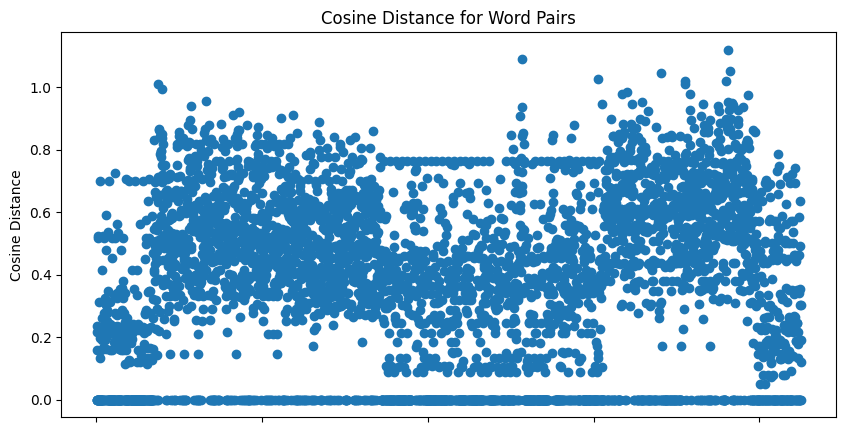

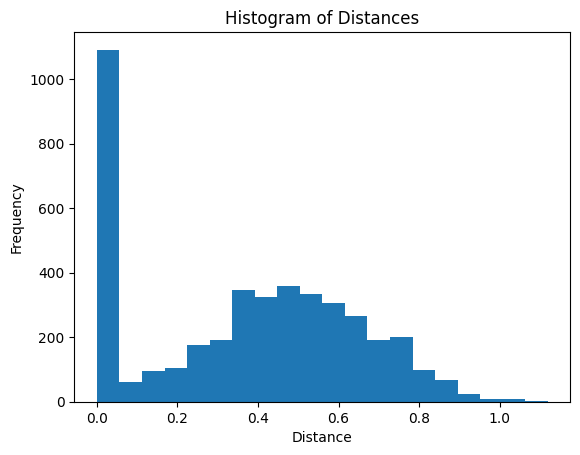

In [ ]:
# Visualize results
plt.figure(figsize=(10, 5))
plt.scatter(range(1, len(distances) + 1), distances)
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
plt.ylabel('Cosine Distance')
plt.title('Cosine Distance for Word Pairs')
plt.show()

plt.hist(distances, bins=20)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances')
plt.show()


---
Sources:

- [Gensim Word2Vec Documentation](https://radimrehurek.com/gensim/models/word2vec.html)
- [NLTK Official Website](https://www.nltk.org/)
- [Word2Vec GitHub Repository](https://github.com/nicholas-leonard/word2vec)
- [Hyperparameter Tuning for Machine Learning Models](https://towardsdatascience.com/hyperparameter-tuning-for-machine-learning-models-1b80d783b946)
- [A Comprehensive Guide on Hyperparameter Tuning and its Techniques](https://www.analyticsvidhya.com/blog/2022/02/a-comprehensive-guide-on-hyperparameter-tuning-and-its-techniques/)
- [Review: Word2Vec - Efficient Estimation of Word Representations in Vector Space](https://sh-tsang.medium.com/review-word2vec-efficient-estimation-of-word-representations-in-vector-space-f9dbe2145afa)
- [Gensim Word2Vec Tutorial on Kaggle](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial)
- [Python Lemmatization with NLTK](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)
- [Gensim Word2Vec Tutorial Starter Code](https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/)